In [3]:

! cat /proc/cpuinfo

!nvidia-smi
# !pkill -3 python3


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [13]:
from zipfile import ZipFile
import shutil
#file_name = "/content/drive/MyDrive/dataset.zip"
#with ZipFile(file_name,'r') as zip:
#    zip.extractall()
#shutil.rmtree("/content/MNIST_JPG_Dataset")

In [26]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import datasets, transforms

class CustomDataset(Dataset):
    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms
        
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]
        class_names.sort()
        if "background" in class_names:
            class_names.remove("background")
            class_names.append("background")
        print(class_names)

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return image, self.labels[index]

    def __len__(self):
        return self.length

In [61]:
#use cuda
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')


#transforms
class make_background_class():
    """
    Args:
        background class number
    """

    def __init__(self, class_num):
        self.class_num = int(class_num)

    def __call__(self, img, target):
        print(img)
        print(target)
        return img, self.class_num

#dataset
"""
dataset structure
train/
    class1/
        *.jpg
    class2/
        *.jpg
    class3/
        *.jpg
    background/
        *.jpg
test/
    class1/
        *.jpg
    class2/
        *.jpg
    class3/
        *.jpg
    background/
        *.jpg
"""

mean=[0.486,0.456,0.406]
std=[0.229,0.224,0.225]
t = [transforms.Resize((160, 160)),
     # transforms.Grayscale(1),
     transforms.ToTensor(),
    transforms.Normalize(mean, std)]
t = transforms.Compose(t)
train_dataset = CustomDataset(data_set_path="./KWS_7class_aug/train", transforms=t)
test_dataset = CustomDataset(data_set_path="./KWS_7class_aug/test", transforms=t)
class_names = os.walk("./KWS_7class_aug/train").__next__()[1]
class_names.sort()
if "background" in class_names:
    class_names.remove("background")
    class_names.append("background")


print('number of training data : ',len(train_dataset))
print('number of test data : ',len(test_dataset))



['a', 'b', 'c', 'd', 'e', 'f', 'g', 'background']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'background']
number of training data :  26008
number of test data :  3058


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


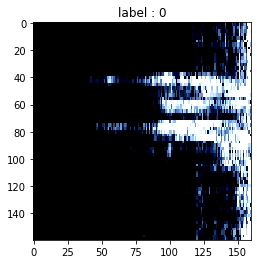

In [62]:
# 파라미터 설정
batch_size = 32
learning_rate = 0.0001
epoch_num = 30

# data 확인
from matplotlib import pyplot as plt

image, label = train_dataset[1]
plt.imshow(image.squeeze().numpy().T)
plt.title('label : %s' % label)
plt.show()


In [63]:
# data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = batch_size, drop_last=True, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size = batch_size, drop_last=True, shuffle = True)


In [64]:
import numpy as np
# Entropic Open-set loss
class Entropic_Open_set_Loss():
    def __init__(self, class_names):
        self.class_num = len(class_names)
        self.batch_size = batch_size
        self.Cross_entropy = nn.CrossEntropyLoss()

    def __call__(self, output, target_batch):
        loss = 0
        for i, target in enumerate(target_batch):
            if target == self.class_num - 1:
                # background class
                div = 1/self.class_num
                for index in range(self.class_num - 1):
                    loss -= torch.log(output[i][index])*div
            else:
                # CELoss
                loss -= torch.log(output[i][target])
                # print(loss)

        loss_mean = loss/len(target_batch)
        return loss_mean
        

In [65]:
# 모델
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Callable, Any, Optional, List
torch.backends.cudnn.enabled = True
__all__ = ['MobileNetV2', 'mobilenet_v2']


model_urls = {
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',
}


  
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNActivation(nn.Sequential):
    def __init__(
        self,
        in_planes: int,
        out_planes: int,
        kernel_size: int = 3,
        stride: int = 1,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        activation_layer: Optional[Callable[..., nn.Module]] = None,
        dilation: int = 1,
    ) -> None:
        padding = (kernel_size - 1) // 2 * dilation
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if activation_layer is None:
            activation_layer = nn.ReLU6
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, dilation=dilation, groups=groups,
                      bias=False),
            norm_layer(out_planes),
            activation_layer(inplace=True)
        )
        self.out_channels = out_planes


# necessary for backwards compatibility
ConvBNReLU = ConvBNActivation


class InvertedResidual(nn.Module):
    def __init__(
        self,
        inp: int,
        oup: int,
        stride: int,
        expand_ratio: int,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    name = 'mobilenetv2'
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        custom_class_num: int = 7,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        """
        MobileNet V2 main class
        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use
        """
        super(MobileNetV2, self).__init__()

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
            nn.Linear(num_classes, custom_class_num)
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)

        x = self.classifier(x)
        output = F.softmax(x, dim=1)
 
        return output

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    #def get_input_size(self):
    #   return 224, 224


def mobilenet_v2(pretrained: bool = True, progress: bool = True, **kwargs: Any) -> MobileNetV2:
    """
    Constructs a MobileNetV2 architecture from
    `"MobileNetV2: Inverted Residuals and Linear Bottlenecks" <https://arxiv.org/abs/1801.04381>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = MobileNetV2(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['mobilenet_v2'],
                                              progress=progress)
        model.load_state_dict(state_dict,strict=False)
    return model

model = mobilenet_v2(custom_class_num = len(class_names) - 1)      
if torch.cuda.is_available():
    model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# criterion = nn.CrossEntropyLoss()

#open set loss
criterion = Entropic_Open_set_Loss(class_names)



In [1]:
# 모델 학습

torch.backends.cudnn.enabled = True
model.train()
i = 1
for epoch in range(epoch_num):
    for data, target in train_loader:
        if torch.cuda.is_available():
            data = data.to(device)
            target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        # print("aaa",loss)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print("Train Step : {}\tLoss : {:3f}".format(i, loss.item()))
            
        i += 1

NameError: name 'torch' is not defined

In [70]:
#모델 평가
model.eval()    # 평가시에는 dropout이 OFF 된다.
correct = 0
no = 0
c = 0
for data, target in test_loader:
    if torch.cuda.is_available():
        data = data.to(device)
        target = target.to(device)
    output = model(data)
    # print(output)
    prediction = torch.max(output[0])
    # print(prediction)
    # print("target", target)
    for i in range(batch_size):
        # print(output[i])
        # print(target[i])
        if torch.max(output[i]) < 0.5 and target[i] == 7:
            c += torch.max(output[i])
            correct += 1
            no +=1
        elif torch.max(output[i]) < 0.5 and target[i] != 10:
            print("No")
            # no += 1
        else:
            correct += torch.argmax(output[i]).eq(target[i])
print("C", c/no)
print("No",no)
print('Test set Accuracy : {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

No
No
No


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 10.76 GiB total capacity; 9.50 GiB already allocated; 7.06 MiB free; 9.63 GiB reserved in total by PyTorch)

In [2]:
!nvidia-smi

Wed Jun  8 07:46:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:19:00.0 Off |                  N/A |
| 40%   38C    P8    12W / 250W |     10MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 41%   

In [20]:
import dataprep
def analyze(model,pos_x=mnist.X_test,pos_y=mnist.labels_test,neg=letters.X_test,file_name='Vanilla_{}.{}',neg_labels='Not_MNIST'):
    mnist_intermediate_output=model_tools.extract_features(model,pos_x,layer_name=['fc','softmax','pred'])
    if neg is not None:
        neg_intermediate_output=model_tools.extract_features(model,neg,layer_name=['fc','softmax','pred'])
    pred_weights=model.get_layer('pred').get_weights()[0]
    
    visualizing_tools.plotter_2D(
                                    mnist_intermediate_output[0],
                                    pos_y,
                                    neg_intermediate_output[0],
                                    final=True,
                                    file_name='LeNet++/Final_Plots/'+file_name,
                                    pos_labels='MNIST Digits',
                                    neg_labels=neg_labels,
                                    pred_weights=pred_weights
                                )
    
    visualizing_tools.plot_softmax_histogram(
                                                mnist_intermediate_output[1],
                                                neg_intermediate_output[1],
                                                file_name='LeNet++/Final_Plots/'+file_name,
                                                pos_labels='MNIST Digits',
                                                neg_labels=neg_labels
                                            )
    gt_y = np.concatenate((mnist.labels_test,np.ones(neg_intermediate_output[1].shape[0])*10),axis=0)
    pred_y = np.concatenate((mnist_intermediate_output[1],neg_intermediate_output[1]),axis=0)
    evaluation_tools.write_file_for_DIR(gt_y,
                                        pred_y,
                                        file_name=('LeNet++/DIRs/'+file_name).format(neg_labels,'txt'),
                                        num_of_known_classes=10
                                       )
    evaluation_tools.write_file_for_DIR(gt_y,
                                        pred_y,
                                        file_name=('LeNet++/DIRs/'+file_name).format(neg_labels,'txt'),
                                        feature_vector=np.concatenate((mnist_intermediate_output[0],neg_intermediate_output[0])),
                                        num_of_known_classes=10
                                       )

NameError: name 'mnist' is not defined